# Dataset

In [31]:
!apt-get -qq install fonts-noto-cjk

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
train_images = np.load(data_path + 'k49-train-imgs.npz')['arr_0']
train_labels = np.load(data_path + 'k49-train-labels.npz')['arr_0']
test_images = np.load(data_path + 'k49-test-imgs.npz')['arr_0']
test_labels = np.load(data_path + 'k49-test-labels.npz')['arr_0']

print(f"Training Images Shape: {train_images.shape}, Type: {train_images.dtype}")
print(f"Training Labels Shape: {train_labels.shape}, Type: {train_labels.dtype}")
print(f"Testing Images Shape: {test_images.shape}, Type: {test_images.dtype}")
print(f"Testing Labels Shape: {test_labels.shape}, Type: {test_labels.dtype}")

Training Images Shape: (232365, 28, 28), Type: uint8
Training Labels Shape: (232365,), Type: uint8
Testing Images Shape: (38547, 28, 28), Type: uint8
Testing Labels Shape: (38547,), Type: uint8


In [34]:
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
prop = fm.FontProperties(fname=font_path)

label_map = {
    0: 'あ', 1: 'い', 2: 'う', 3: 'え', 4: 'お',
    5: 'か', 6: 'き', 7: 'く', 8: 'け', 9: 'こ',
    10: 'さ', 11: 'し', 12: 'す', 13: 'せ', 14: 'そ',
    15: 'た', 16: 'ち', 17: 'つ', 18: 'て', 19: 'と',
    20: 'な', 21: 'に', 22: 'ぬ', 23: 'ね', 24: 'の',
    25: 'は', 26: 'ひ', 27: 'ふ', 28: 'へ', 29: 'ほ',
    30: 'ま', 31: 'み', 32: 'む', 33: 'め', 34: 'も',
    35: 'や', 36: 'ゆ', 37: 'よ', 38: 'ら', 39: 'り',
    40: 'る', 41: 'れ', 42: 'ろ', 43: 'わ', 44: 'を',
    45: 'ん', 46: 'ゝ', 47: 'ゞ', 48: 'ー'
}

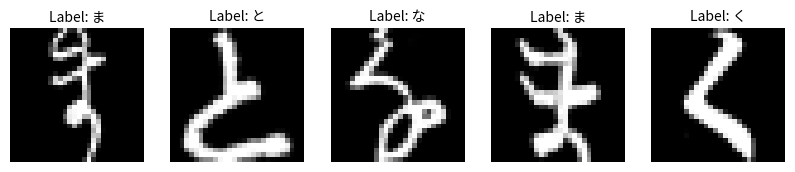

In [35]:
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {label_map[train_labels[i]]}", fontproperties=prop)
    plt.axis('off')
plt.show()

# Modelling

In [36]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn.functional as F

class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot_targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        loss = 1 - F.cosine_similarity(inputs, one_hot_targets, dim=1)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
batch_size = 32
learning_rate = 0.1
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

## Transformer

### Cross Entropy Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def load_k49_data():
    train_images = np.load(data_path + 'k49-train-imgs.npz')['arr_0']
    train_labels = np.load(data_path + 'k49-train-labels.npz')['arr_0']
    test_images = np.load(data_path + 'k49-test-imgs.npz')['arr_0']
    test_labels = np.load(data_path + 'k49-test-labels.npz')['arr_0']

    train_images = torch.tensor(train_images).float() / 255.0
    test_images = torch.tensor(test_images).float() / 255.0
    train_labels = torch.tensor(train_labels).long()
    test_labels = torch.tensor(test_labels).long()

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_k49_data()
dataset = TensorDataset(train_images, train_labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = TensorDataset(test_images, test_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, nhead=2, num_encoder_layers=2, dim_feedforward=64, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(dim_feedforward, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1).unsqueeze(1)  # [batch_size, 1, num_pixels]
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # [1, batch_size, dim_feedforward]
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        return self.fc(x)

In [ ]:
def train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, batch_size=32):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects / len(dataloaders['val'].dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")

    return history

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_training_vs_epochs(history, test_acc, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(history['train_loss'], label='Training Loss', color='tab:blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='tab:orange')
    ax2.plot(history['train_acc'], label='Training Accuracy', color='tab:green')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='tab:red')
    ax2.axhline(y=test_acc, color='tab:purple', linestyle='--', label='Test Accuracy')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 1.0640, Acc: 0.7169, Val Loss: 0.7299, Val Acc: 0.8007
Epoch [2/5], Loss: 0.7328, Acc: 0.7972, Val Loss: 0.6394, Val Acc: 0.8246
Epoch [3/5], Loss: 0.6029, Acc: 0.8323, Val Loss: 0.5434, Val Acc: 0.8526
Epoch [4/5], Loss: 0.5703, Acc: 0.8397, Val Loss: 0.5267, Val Acc: 0.8565
Epoch [5/5], Loss: 0.5202, Acc: 0.8555, Val Loss: 0.4914, Val Acc: 0.8663


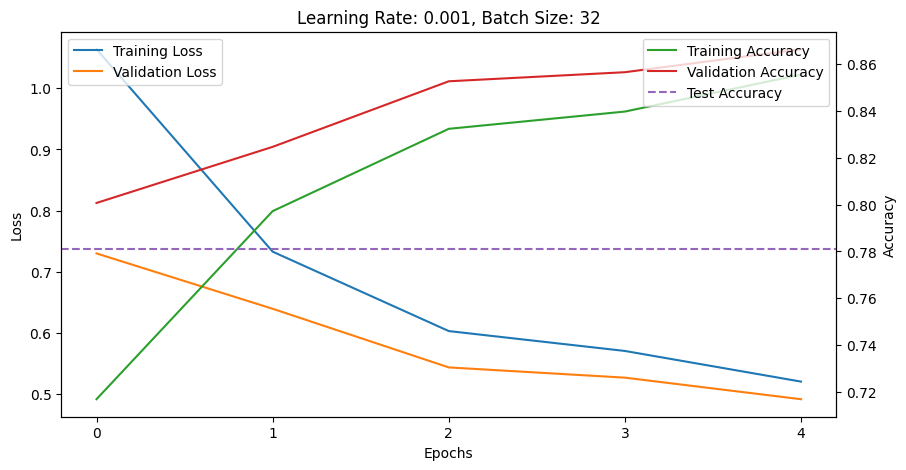

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Cosine Similarity Loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Loss: 0.3946, Acc: 0.6344, Val Loss: 0.2792, Val Acc: 0.7176
Epoch [2/5], Loss: 0.2957, Acc: 0.7150, Val Loss: 0.2427, Val Acc: 0.7478
Epoch [3/5], Loss: 0.2627, Acc: 0.7498, Val Loss: 0.2168, Val Acc: 0.7763
Epoch [4/5], Loss: 0.2543, Acc: 0.7579, Val Loss: 0.2131, Val Acc: 0.7788
Epoch [5/5], Loss: 0.2424, Acc: 0.7726, Val Loss: 0.2023, Val Acc: 0.7916


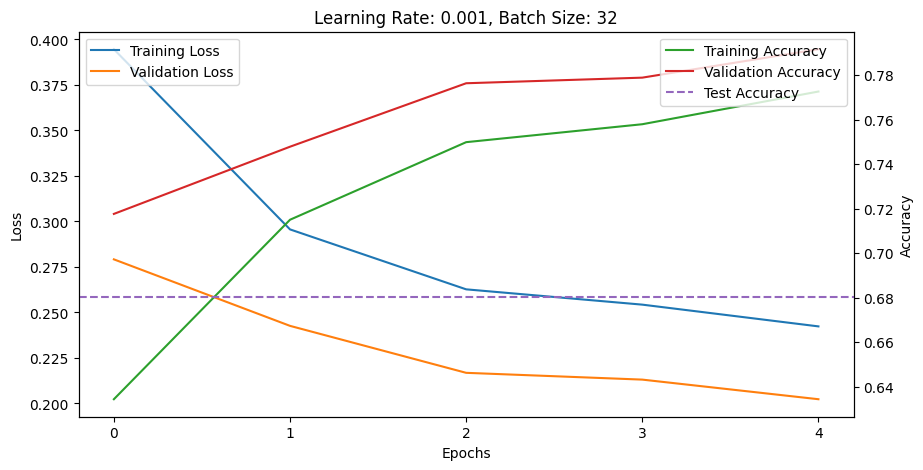

In [ ]:
import torch.nn.functional as F

class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot_targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        loss = 1 - F.cosine_similarity(inputs, one_hot_targets, dim=1)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

batch_size = 32
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Higher Learning Rate

Epoch [1/5], Loss: 2.0481, Acc: 0.4379, Val Loss: 1.8294, Val Acc: 0.4949
Epoch [2/5], Loss: 1.8604, Acc: 0.4893, Val Loss: 1.7002, Val Acc: 0.5333
Epoch [3/5], Loss: 1.6982, Acc: 0.5320, Val Loss: 1.5646, Val Acc: 0.5665
Epoch [4/5], Loss: 1.6649, Acc: 0.5396, Val Loss: 1.5535, Val Acc: 0.5677
Epoch [5/5], Loss: 1.5925, Acc: 0.5583, Val Loss: 1.4561, Val Acc: 0.5951


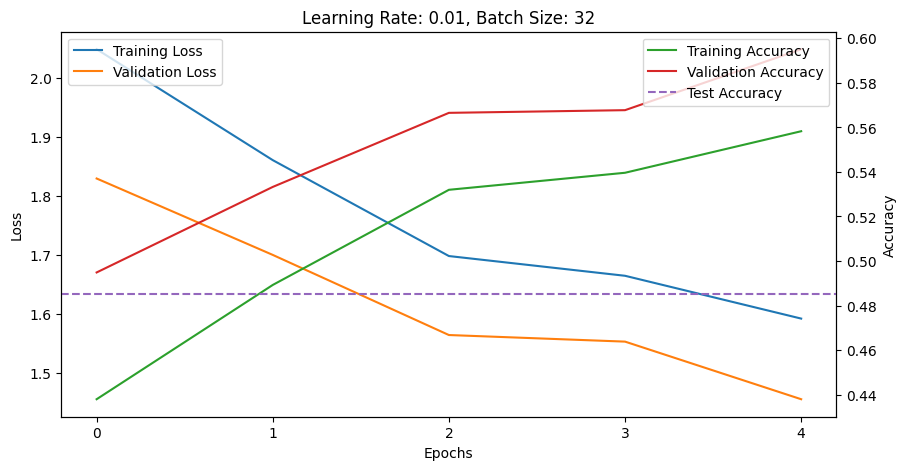

In [ ]:
batch_size = 32
learning_rate = 0.01
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

Epoch [1/5], Loss: 0.5292, Acc: 0.4283, Val Loss: 0.4405, Val Acc: 0.5226
Epoch [2/5], Loss: 0.4753, Acc: 0.4968, Val Loss: 0.4239, Val Acc: 0.5353
Epoch [3/5], Loss: 0.4400, Acc: 0.5351, Val Loss: 0.3960, Val Acc: 0.5647
Epoch [4/5], Loss: 0.4351, Acc: 0.5418, Val Loss: 0.3882, Val Acc: 0.5724
Epoch [5/5], Loss: 0.4203, Acc: 0.5599, Val Loss: 0.3759, Val Acc: 0.5904


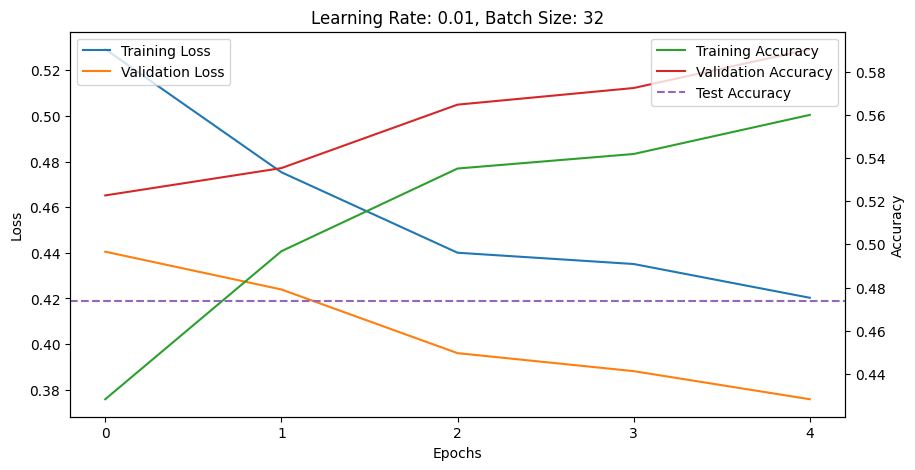

In [ ]:
import torch.nn.functional as F

batch_size = 32
learning_rate = 0.01
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Higher Batch Size

Epoch [1/5], Loss: 1.1232, Acc: 0.7057, Val Loss: 0.7561, Val Acc: 0.7945
Epoch [2/5], Loss: 0.7480, Acc: 0.7945, Val Loss: 0.6280, Val Acc: 0.8306
Epoch [3/5], Loss: 0.6185, Acc: 0.8281, Val Loss: 0.5614, Val Acc: 0.8486
Epoch [4/5], Loss: 0.5871, Acc: 0.8362, Val Loss: 0.5462, Val Acc: 0.8515
Epoch [5/5], Loss: 0.5380, Acc: 0.8504, Val Loss: 0.5068, Val Acc: 0.8626


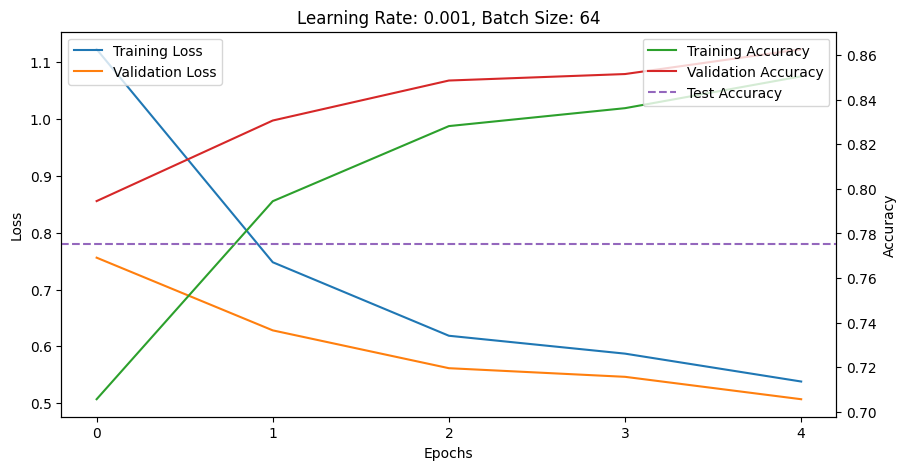

In [ ]:
batch_size = 64
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

Epoch [1/5], Loss: 0.4156, Acc: 0.6211, Val Loss: 0.2945, Val Acc: 0.7161
Epoch [2/5], Loss: 0.3043, Acc: 0.7123, Val Loss: 0.2462, Val Acc: 0.7497
Epoch [3/5], Loss: 0.2706, Acc: 0.7464, Val Loss: 0.2254, Val Acc: 0.7719
Epoch [4/5], Loss: 0.2607, Acc: 0.7569, Val Loss: 0.2178, Val Acc: 0.7787
Epoch [5/5], Loss: 0.2484, Acc: 0.7695, Val Loss: 0.2102, Val Acc: 0.7857


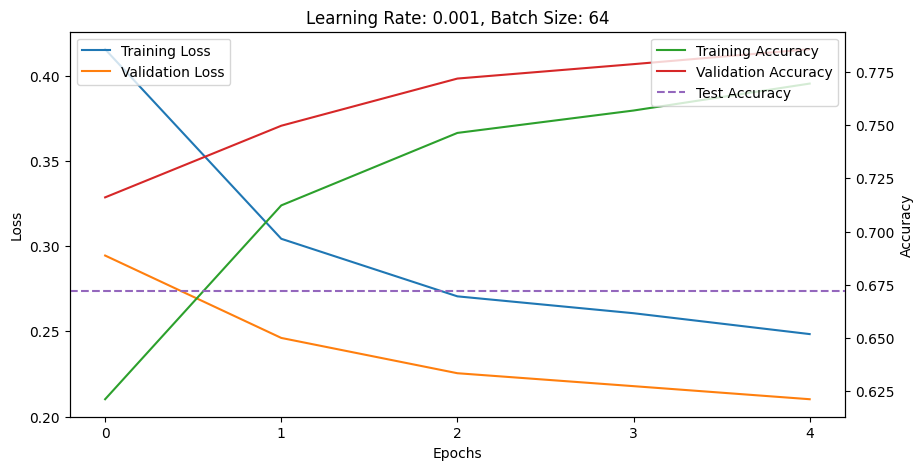

In [ ]:
import torch.nn.functional as F

batch_size = 64
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = TransformerClassifier(input_dim=28 * 28, num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Predicted Visualization

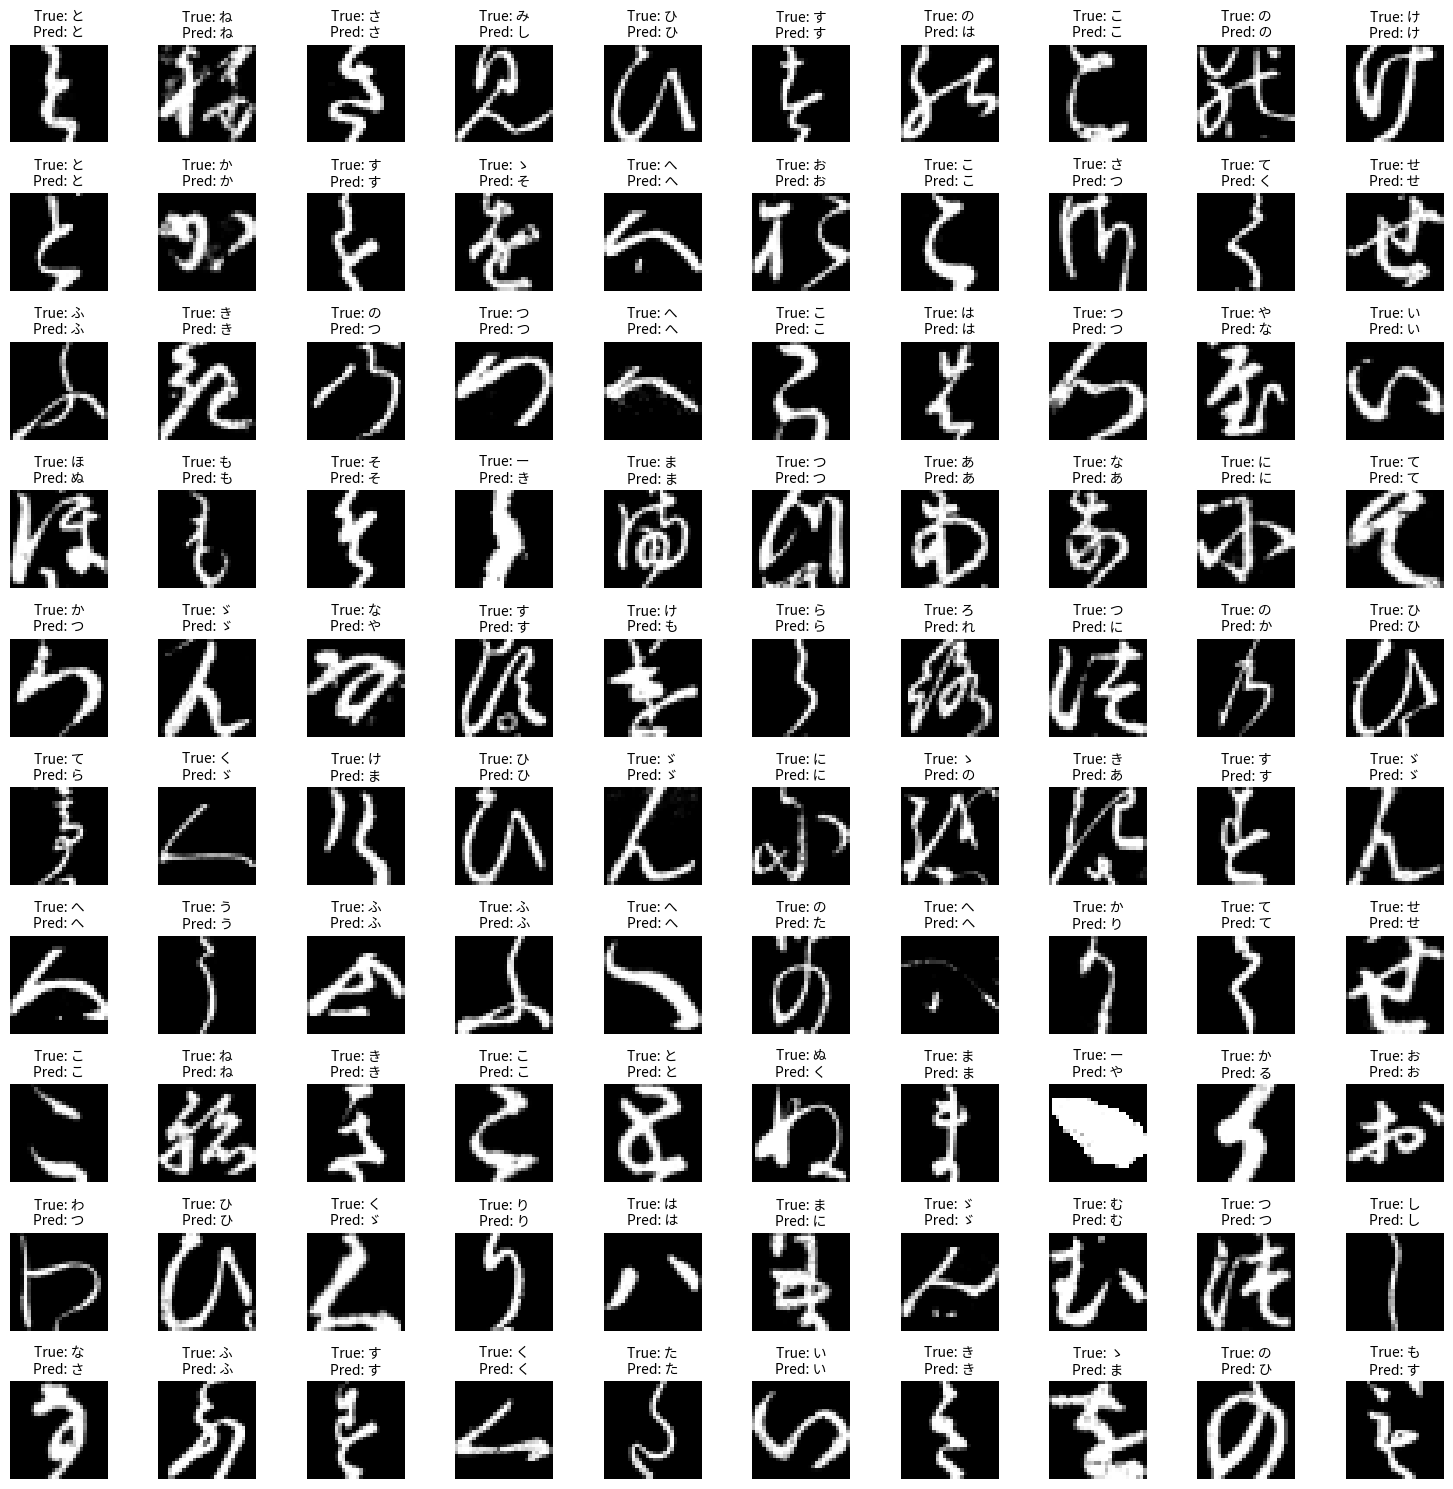

In [ ]:
n_samples = 100
rows = 10
cols = 10

images_list = []
labels_list = []

for batch_images, batch_labels in test_loader:
    images_list.append(batch_images)
    labels_list.append(batch_labels)
    if len(torch.cat(images_list)) >= n_samples:
        break

images = torch.cat(images_list)[:n_samples]
labels = torch.cat(labels_list)[:n_samples]

with torch.no_grad():
    outputs = model(images.to(device))
    preds = outputs.argmax(dim=1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, (image, label, pred) in enumerate(zip(images, labels, preds)):
    row, col = divmod(i, cols)
    axs[row, col].imshow(image.cpu().numpy().squeeze(), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label_map[label.item()]}\nPred: {label_map[pred.item()]}", fontproperties=prop)

for ax in axs.flat[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


### Summary

- Model: Transformer
- Loss Function: Cross Entropy and Cosine Similarity
- Optimizer: Adam
- Other Hyperparameters:
    - Batch Size: 32 and 64
    - Learning Rate: 0.001 and 0.01
    - Number of Epochs: 5



## Auxiliary Classifier GAN

### Cross Entropy Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def load_k49_data():
    train_images = np.load(data_path + 'k49-train-imgs.npz')['arr_0']
    train_labels = np.load(data_path + 'k49-train-labels.npz')['arr_0']
    test_images = np.load(data_path + 'k49-test-imgs.npz')['arr_0']
    test_labels = np.load(data_path + 'k49-test-labels.npz')['arr_0']

    train_images = torch.tensor(train_images).float() / 255.0
    test_images = torch.tensor(test_images).float() / 255.0
    train_labels = torch.tensor(train_labels).long()
    test_labels = torch.tensor(test_labels).long()

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_k49_data()
dataset = TensorDataset(train_images, train_labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = TensorDataset(test_images, test_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
latent_dim = 100
num_classes = 49
image_size = 28

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        input_vector = torch.cat((noise, label_input), -1)
        return self.model(input_vector).view(-1, 1, image_size, image_size)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.validity_layer = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.aux_classifier = nn.Sequential(
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        features = self.model(x)
        validity = self.validity_layer(features)
        label = self.aux_classifier(features)
        return validity, label

In [ ]:
def train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=5, latent_dim=100):
    history = {'G_loss': [], 'D_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        for i, (imgs, labels) in enumerate(dataloaders['train']):
            batch_size = imgs.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            imgs, labels = imgs.to(device), labels.to(device)

            noise = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)

            optimizer_G.zero_grad()
            gen_imgs = generator(noise, gen_labels)
            validity, pred_labels = discriminator(gen_imgs)
            g_loss = criterion_GAN(validity, real_labels) + criterion_aux(pred_labels, gen_labels)
            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()
            real_validity, real_pred_labels = discriminator(imgs)
            d_real_loss = criterion_GAN(real_validity, real_labels) + criterion_aux(real_pred_labels, labels)

            fake_validity, fake_pred_labels = discriminator(gen_imgs.detach())
            d_fake_loss = criterion_GAN(fake_validity, fake_labels) + criterion_aux(fake_pred_labels, gen_labels)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        history['G_loss'].append(g_loss.item())
        history['D_loss'].append(d_loss.item())

        generator.eval()
        discriminator.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in dataloaders['val']:
                imgs, labels = imgs.to(device), labels.to(device)
                _, pred_labels = discriminator(imgs)
                pred_labels = pred_labels.argmax(dim=1)
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}, Validation Accuracy: {val_acc:.4f}")

    return history


In [ ]:
def plot_GAN_training_vs_epochs(history, test_acc, title="ACGAN Training and Validation Results"):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(history['G_loss'], label='Generator Loss', color='tab:blue')
    ax1.plot(history['D_loss'], label='Discriminator Loss', color='tab:orange')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='tab:red')
    ax2.axhline(y=test_acc, color='tab:purple', linestyle='--', label='Test Accuracy')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(title)
    plt.show()

In [ ]:
def classify_text(images):
    discriminator.eval()
    with torch.no_grad():
        _, pred_labels = discriminator(images.to(device))
        return pred_labels.argmax(dim=1)

def evaluate_on_test_set(discriminator, test_loader):
    discriminator.eval()
    running_corrects = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            pred_labels = classify_text(imgs)
            running_corrects += (pred_labels.cpu() == labels).sum().item()
    test_acc = running_corrects / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

Epoch [1/5], Generator Loss: 6.1512, Discriminator Loss: 4.0374, Validation Accuracy: 0.1352
Epoch [2/5], Generator Loss: 5.1667, Discriminator Loss: 3.9545, Validation Accuracy: 0.2400
Epoch [3/5], Generator Loss: 5.2549, Discriminator Loss: 4.1642, Validation Accuracy: 0.2544
Epoch [4/5], Generator Loss: 5.0302, Discriminator Loss: 4.2182, Validation Accuracy: 0.2722
Epoch [5/5], Generator Loss: 4.5961, Discriminator Loss: 3.7936, Validation Accuracy: 0.2870
Test Accuracy: 0.2486


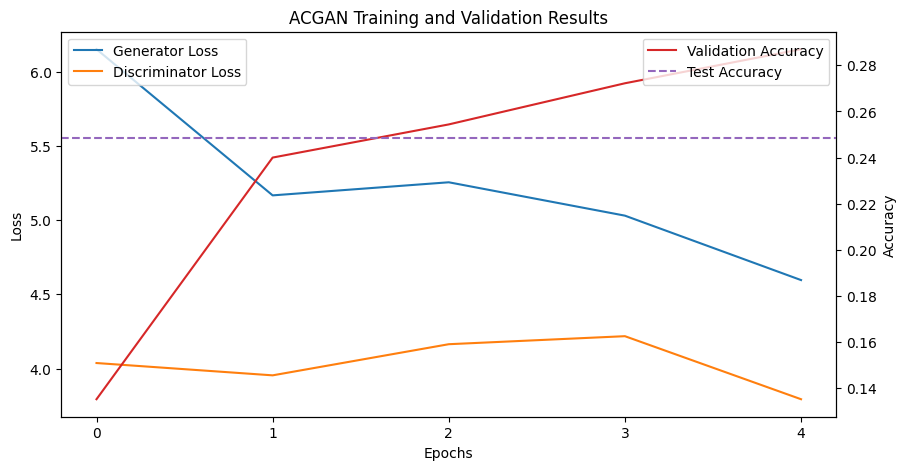

In [ ]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = nn.CrossEntropyLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

### Cosine Similarity Loss

Epoch [1/5], Generator Loss: 1.5590, Discriminator Loss: 0.6385, Validation Accuracy: 0.3524
Epoch [2/5], Generator Loss: 1.8318, Discriminator Loss: 1.2978, Validation Accuracy: 0.4573
Epoch [3/5], Generator Loss: 2.2735, Discriminator Loss: 0.9716, Validation Accuracy: 0.5106
Epoch [4/5], Generator Loss: 1.4195, Discriminator Loss: 1.1549, Validation Accuracy: 0.5388
Epoch [5/5], Generator Loss: 1.2278, Discriminator Loss: 0.9447, Validation Accuracy: 0.5591
Test Accuracy: 0.4421


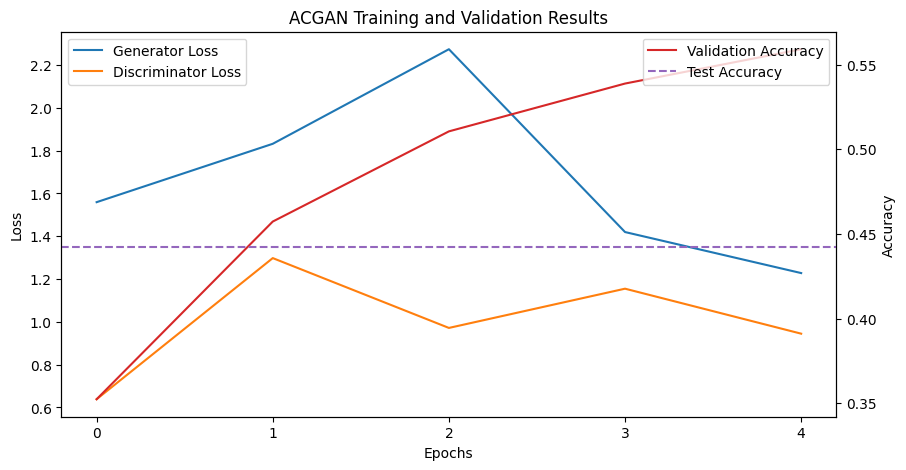

In [ ]:
class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot_targets = torch.nn.functional.one_hot(targets, num_classes=inputs.size(1)).float()
        loss = 1 - torch.nn.functional.cosine_similarity(inputs, one_hot_targets, dim=1)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

batch_size = 32
learning_rate = 0.0001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = CosineSimilarityLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

### Higher Learning Rate

Epoch [1/5], Generator Loss: 4.4124, Discriminator Loss: 3.9729, Validation Accuracy: 0.3896
Epoch [2/5], Generator Loss: 4.7776, Discriminator Loss: 4.2923, Validation Accuracy: 0.4347
Epoch [3/5], Generator Loss: 4.9368, Discriminator Loss: 3.9841, Validation Accuracy: 0.4515
Epoch [4/5], Generator Loss: 4.5085, Discriminator Loss: 4.1238, Validation Accuracy: 0.4349
Epoch [5/5], Generator Loss: 5.0938, Discriminator Loss: 4.0457, Validation Accuracy: 0.4399
Test Accuracy: 0.3665


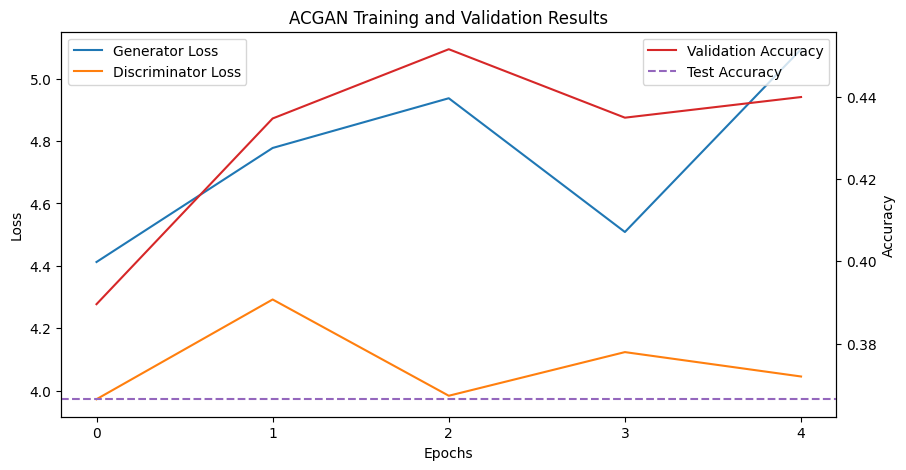

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = nn.CrossEntropyLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

Epoch [1/5], Generator Loss: 0.8899, Discriminator Loss: 0.9137, Validation Accuracy: 0.5924
Epoch [2/5], Generator Loss: 1.0077, Discriminator Loss: 0.9396, Validation Accuracy: 0.6259
Epoch [3/5], Generator Loss: 1.0951, Discriminator Loss: 0.9744, Validation Accuracy: 0.6556
Epoch [4/5], Generator Loss: 0.8485, Discriminator Loss: 0.6438, Validation Accuracy: 0.6391
Epoch [5/5], Generator Loss: 1.0030, Discriminator Loss: 0.8015, Validation Accuracy: 0.6795
Test Accuracy: 0.5575


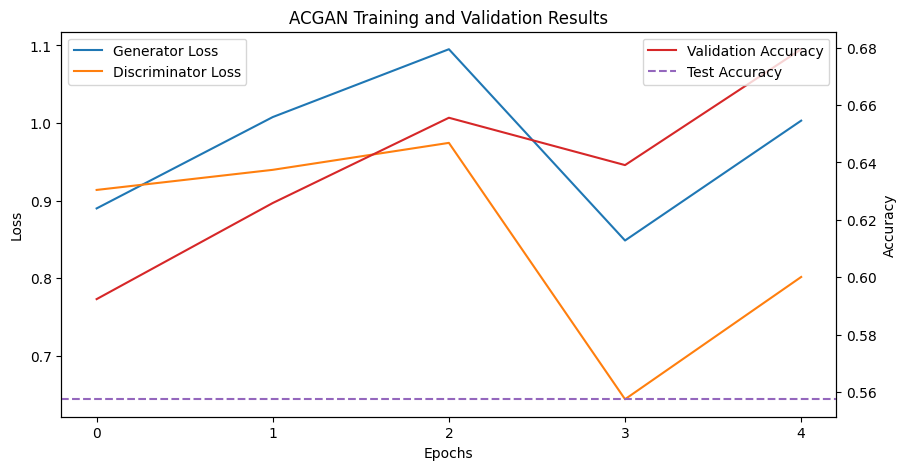

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = CosineSimilarityLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

### Higher Batch Size

Epoch [1/5], Generator Loss: 4.9156, Discriminator Loss: 4.2980, Validation Accuracy: 0.0723
Epoch [2/5], Generator Loss: 5.1266, Discriminator Loss: 4.1072, Validation Accuracy: 0.1766
Epoch [3/5], Generator Loss: 4.4436, Discriminator Loss: 4.1332, Validation Accuracy: 0.2623
Epoch [4/5], Generator Loss: 4.5260, Discriminator Loss: 4.4063, Validation Accuracy: 0.2952
Epoch [5/5], Generator Loss: 4.6544, Discriminator Loss: 4.2372, Validation Accuracy: 0.3185
Test Accuracy: 0.2596


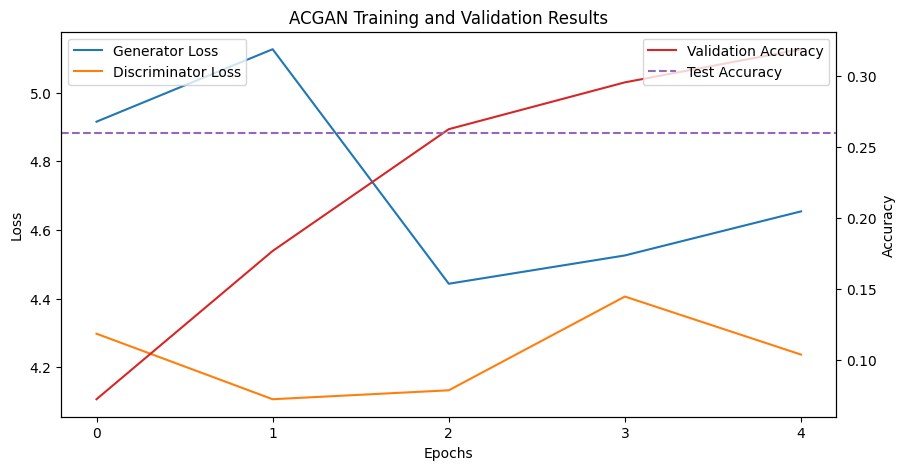

In [ ]:
batch_size = 64
learning_rate = 0.0001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = nn.CrossEntropyLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

Epoch [1/5], Generator Loss: 1.1973, Discriminator Loss: 0.7450, Validation Accuracy: 0.3410
Epoch [2/5], Generator Loss: 1.3431, Discriminator Loss: 0.8709, Validation Accuracy: 0.3763
Epoch [3/5], Generator Loss: 1.2101, Discriminator Loss: 0.7854, Validation Accuracy: 0.4184
Epoch [4/5], Generator Loss: 0.9348, Discriminator Loss: 0.7752, Validation Accuracy: 0.4466
Epoch [5/5], Generator Loss: 0.9339, Discriminator Loss: 0.7465, Validation Accuracy: 0.4656
Test Accuracy: 0.3589


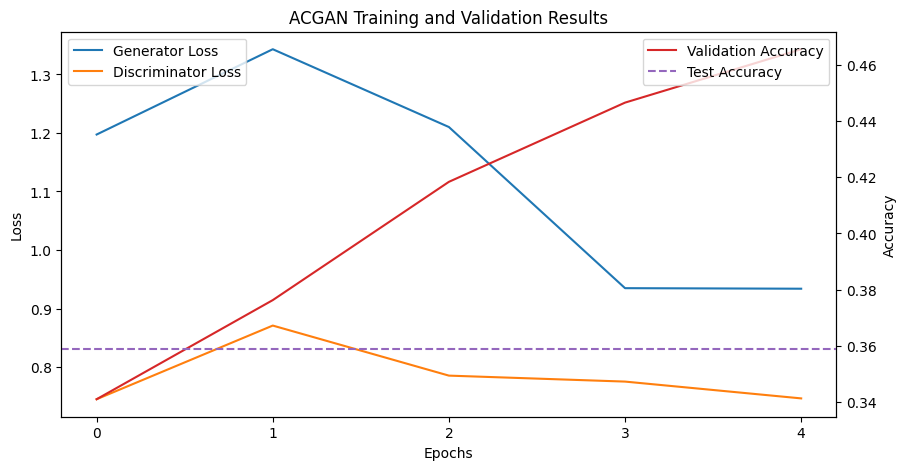

In [ ]:
batch_size = 64
learning_rate = 0.0001
num_epochs = 5
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion_GAN = nn.BCELoss()
criterion_aux = CosineSimilarityLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
history = train_and_evaluate_GAN(generator, discriminator, criterion_GAN, criterion_aux, optimizer_G, optimizer_D, dataloaders, num_epochs=num_epochs)

test_acc = evaluate_on_test_set(discriminator, test_loader)
plot_GAN_training_vs_epochs(history, test_acc)

### Predicted Visualization

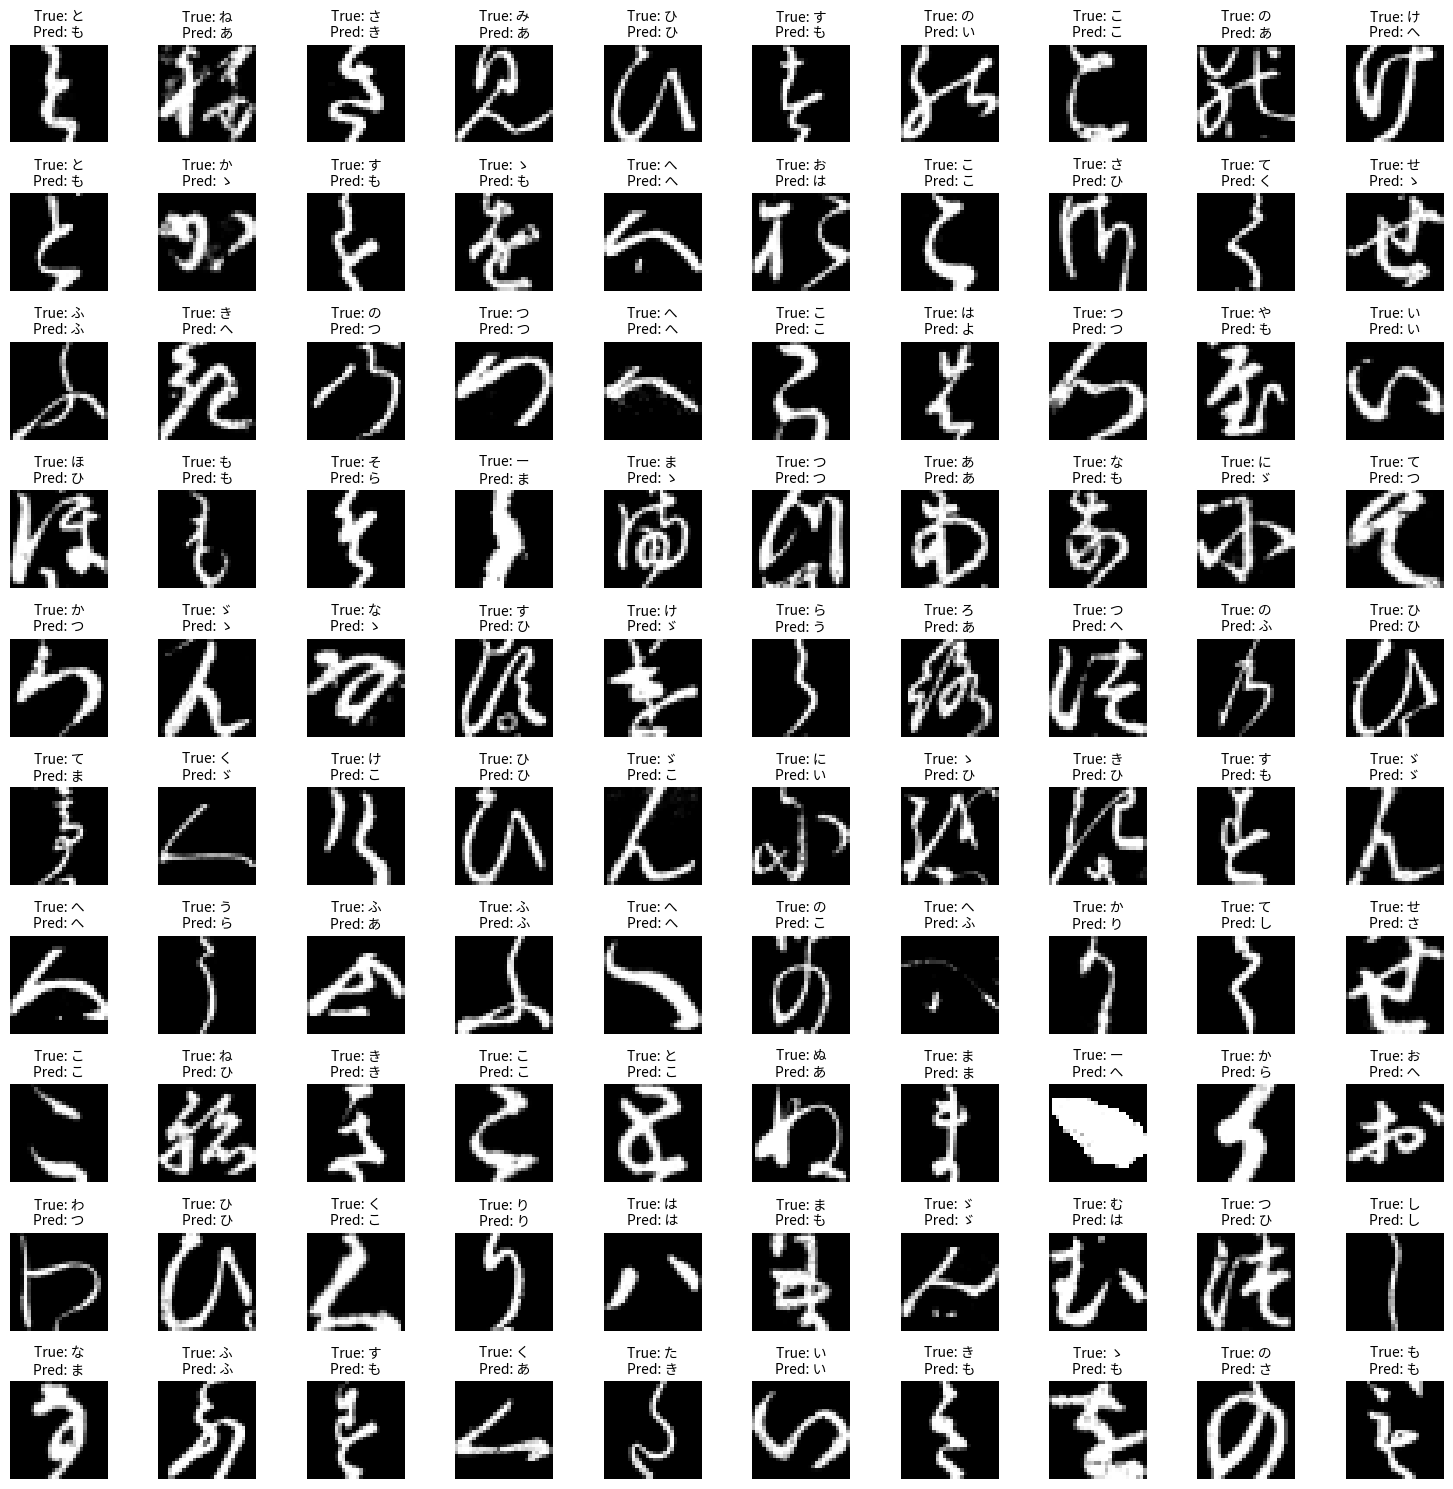

In [ ]:
n_samples = 100
rows = 10
cols = 10

images_list = []
labels_list = []

for batch_images, batch_labels in test_loader:
    images_list.append(batch_images)
    labels_list.append(batch_labels)
    if len(torch.cat(images_list)) >= n_samples:
        break

images = torch.cat(images_list)[:n_samples]
labels = torch.cat(labels_list)[:n_samples]

with torch.no_grad():
    _, preds = discriminator(images.to(device))
    preds = preds.argmax(dim=1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, (image, label, pred) in enumerate(zip(images, labels, preds)):
    row, col = divmod(i, cols)
    axs[row, col].imshow(image.cpu().numpy().squeeze(), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label_map[label.item()]}\nPred: {label_map[pred.item()]}", fontproperties=prop)

for ax in axs.flat[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Summary

- Model: ACGAN
- Loss Function: Cross Entropy and Cosine Similarity
- Optimizer: Adam
- Other Hyperparameters:
    - Batch Size: 32 and 64
    - Learning Rate: 0.0001 and 0.001
    - Number of Epochs: 5



## CNN

### Cross Entropy Loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to load the dataset
def load_k49_data():
    train_images = np.load(data_path + 'k49-train-imgs.npz')['arr_0']
    train_labels = np.load(data_path + 'k49-train-labels.npz')['arr_0']
    test_images = np.load(data_path + 'k49-test-imgs.npz')['arr_0']
    test_labels = np.load(data_path + 'k49-test-labels.npz')['arr_0']

    train_images = torch.tensor(train_images).float() / 255.0
    test_images = torch.tensor(test_images).float() / 255.0
    train_labels = torch.tensor(train_labels).long()
    test_labels = torch.tensor(test_labels).long()

    return train_images, train_labels, test_images, test_labels

# Load the dataset
train_images, train_labels, test_images, test_labels = load_k49_data()

# Convert the dataset to TensorDataset
train_dataset = TensorDataset(train_images.unsqueeze(1), train_labels)
test_dataset = TensorDataset(test_images.unsqueeze(1), test_labels)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# Define the CNN model
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)  # Flatten the features
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Define the training and evaluation function
def train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, batch_size=32):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects / len(dataloaders['val'].dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")

    return history

In [ ]:
# Function to plot training process
def plot_training_vs_epochs(history, test_acc, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(history['train_loss'], label='Training Loss', color='tab:blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='tab:orange')
    ax2.plot(history['train_acc'], label='Training Accuracy', color='tab:green')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='tab:red')
    ax2.axhline(y=test_acc, color='tab:purple', linestyle='--', label='Test Accuracy')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(title)
    plt.show()

Epoch [1/5], Loss: 0.5678, Acc: 0.8475, Val Loss: 0.3172, Val Acc: 0.9119
Epoch [2/5], Loss: 0.2542, Acc: 0.9294, Val Loss: 0.2392, Val Acc: 0.9342
Epoch [3/5], Loss: 0.1577, Acc: 0.9559, Val Loss: 0.2062, Val Acc: 0.9449
Epoch [4/5], Loss: 0.1298, Acc: 0.9631, Val Loss: 0.2053, Val Acc: 0.9461
Epoch [5/5], Loss: 0.0907, Acc: 0.9749, Val Loss: 0.1953, Val Acc: 0.9498


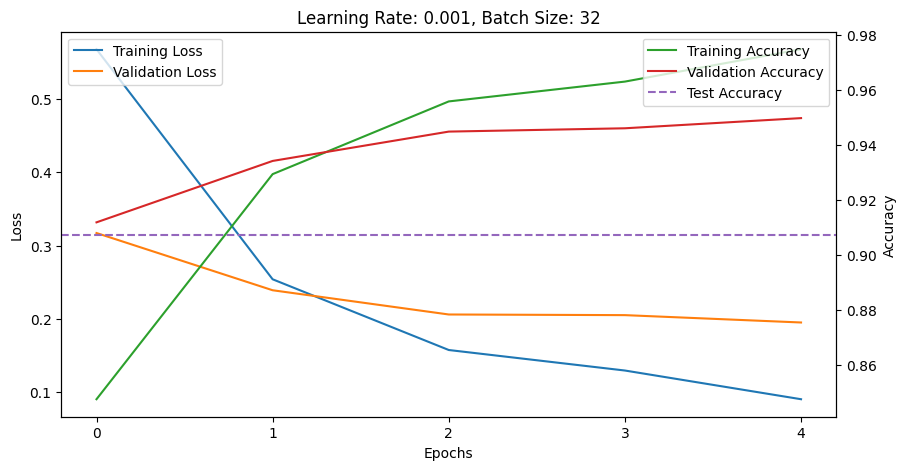

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

# Instantiate the model, loss function, and optimizer
model = CNNClassifier(num_classes=49).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Train and evaluate the model
history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

# Evaluate the model on the test set
model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

# Plot the training process
plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Cosine Similarity Loss

Epoch [1/5], Loss: 0.1896, Acc: 0.8567, Val Loss: 0.0861, Val Acc: 0.9155
Epoch [2/5], Loss: 0.0729, Acc: 0.9273, Val Loss: 0.0687, Val Acc: 0.9298
Epoch [3/5], Loss: 0.0551, Acc: 0.9445, Val Loss: 0.0657, Val Acc: 0.9321
Epoch [4/5], Loss: 0.0504, Acc: 0.9491, Val Loss: 0.0645, Val Acc: 0.9323
Epoch [5/5], Loss: 0.0451, Acc: 0.9539, Val Loss: 0.0614, Val Acc: 0.9354


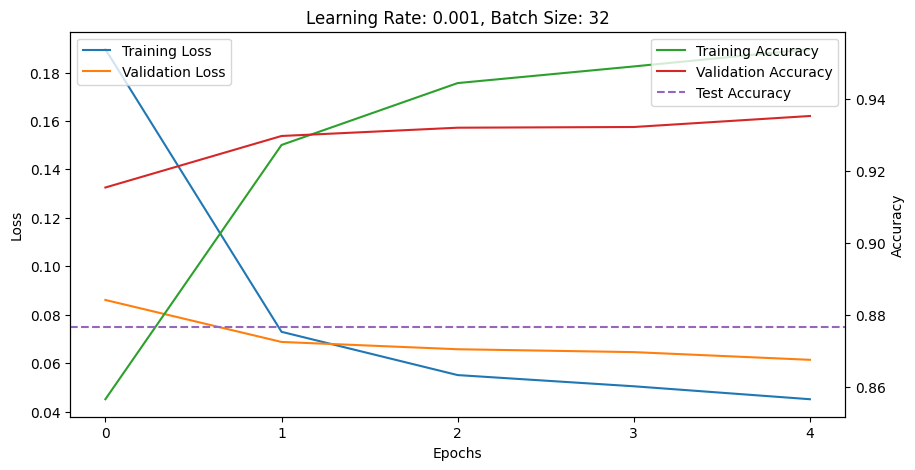

In [ ]:
import torch.nn.functional as F

class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot_targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        loss = 1 - F.cosine_similarity(inputs, one_hot_targets, dim=1)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

batch_size = 32
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = CNNClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Higher Learning Rate（Two kinds of loss funct）

Epoch [1/5], Loss: 3.8893, Acc: 0.0256, Val Loss: 3.8213, Val Acc: 0.0258
Epoch [2/5], Loss: 3.8248, Acc: 0.0258, Val Loss: 3.8213, Val Acc: 0.0257
Epoch [3/5], Loss: 3.8108, Acc: 0.0260, Val Loss: 3.8082, Val Acc: 0.0262
Epoch [4/5], Loss: 3.8103, Acc: 0.0257, Val Loss: 3.8102, Val Acc: 0.0259
Epoch [5/5], Loss: 3.8032, Acc: 0.0252, Val Loss: 3.8005, Val Acc: 0.0269


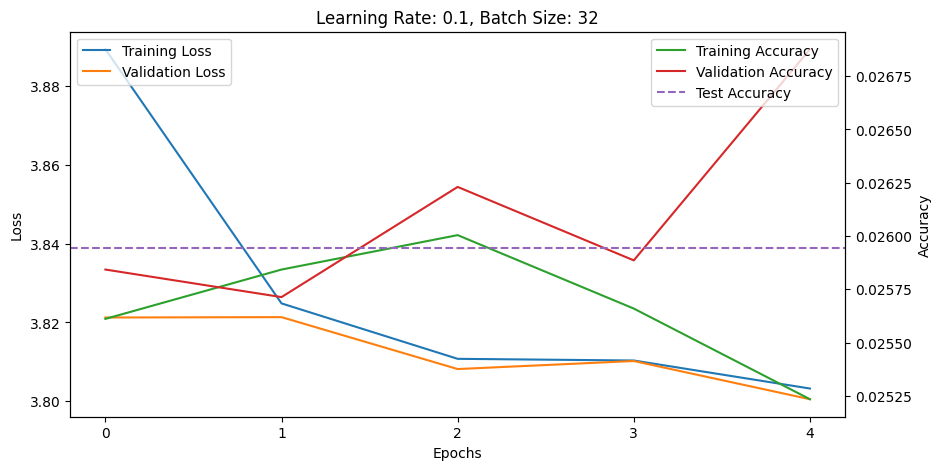

In [ ]:
batch_size = 32
learning_rate = 0.1
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = CNNClassifier(num_classes=49).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

Epoch [1/5], Loss: 0.3334, Acc: 0.6446, Val Loss: 0.3039, Val Acc: 0.6643
Epoch [2/5], Loss: 0.3559, Acc: 0.6018, Val Loss: 0.3270, Val Acc: 0.6360
Epoch [3/5], Loss: 0.2705, Acc: 0.7010, Val Loss: 0.2394, Val Acc: 0.7359
Epoch [4/5], Loss: 0.2693, Acc: 0.6964, Val Loss: 0.2751, Val Acc: 0.6903
Epoch [5/5], Loss: 0.2590, Acc: 0.7076, Val Loss: 0.2598, Val Acc: 0.7074


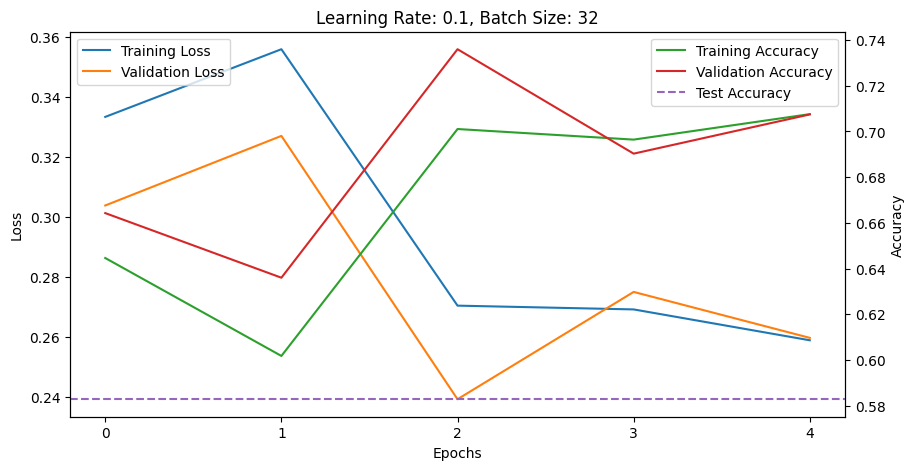

In [ ]:
batch_size = 32
learning_rate = 0.1
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = CNNClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Lower Batch Size（Two kinds of loss funct）

Epoch [1/5], Loss: 0.5278, Acc: 0.8569, Val Loss: 0.3048, Val Acc: 0.9163
Epoch [2/5], Loss: 0.2393, Acc: 0.9325, Val Loss: 0.2419, Val Acc: 0.9331
Epoch [3/5], Loss: 0.1455, Acc: 0.9590, Val Loss: 0.1973, Val Acc: 0.9472
Epoch [4/5], Loss: 0.1170, Acc: 0.9669, Val Loss: 0.2068, Val Acc: 0.9471
Epoch [5/5], Loss: 0.0801, Acc: 0.9780, Val Loss: 0.1969, Val Acc: 0.9515


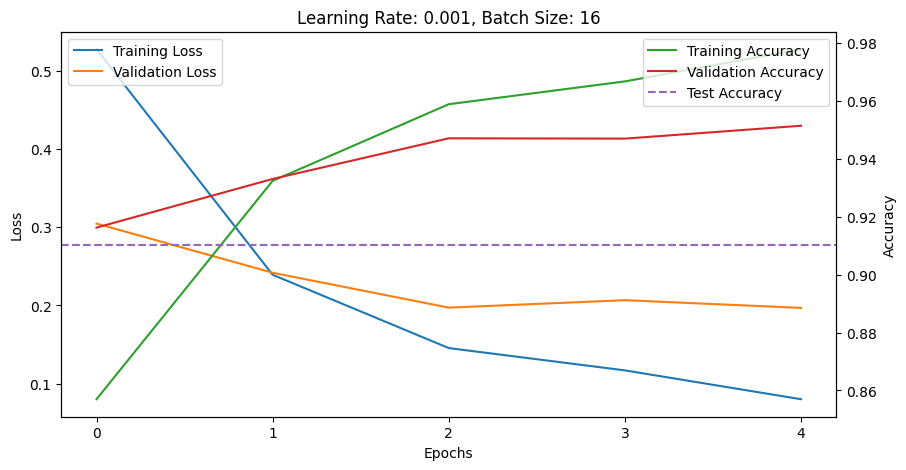

In [ ]:
batch_size = 16
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = CNNClassifier(num_classes=49).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

Epoch [1/5], Loss: 0.1548, Acc: 0.8725, Val Loss: 0.0868, Val Acc: 0.9126
Epoch [2/5], Loss: 0.0735, Acc: 0.9258, Val Loss: 0.0729, Val Acc: 0.9239
Epoch [3/5], Loss: 0.0584, Acc: 0.9397, Val Loss: 0.0695, Val Acc: 0.9268
Epoch [4/5], Loss: 0.0558, Acc: 0.9423, Val Loss: 0.0667, Val Acc: 0.9291
Epoch [5/5], Loss: 0.0496, Acc: 0.9486, Val Loss: 0.0673, Val Acc: 0.9279


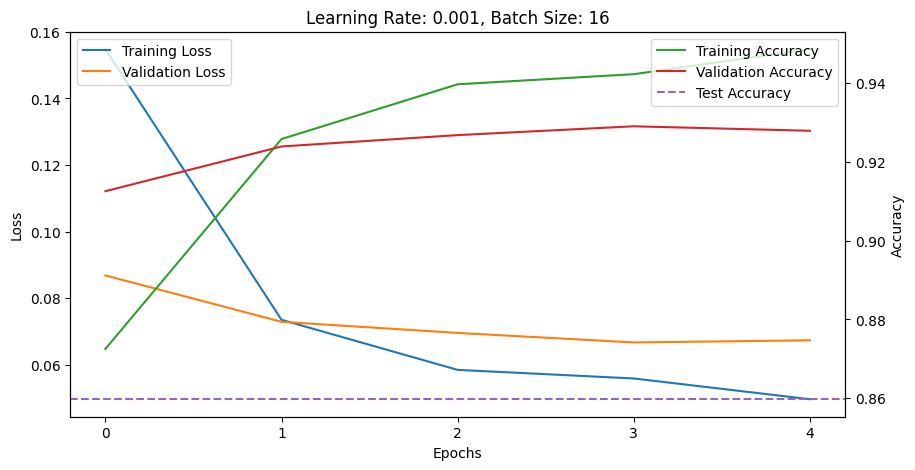

In [ ]:
batch_size = 16
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = CNNClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Predicted Visualization

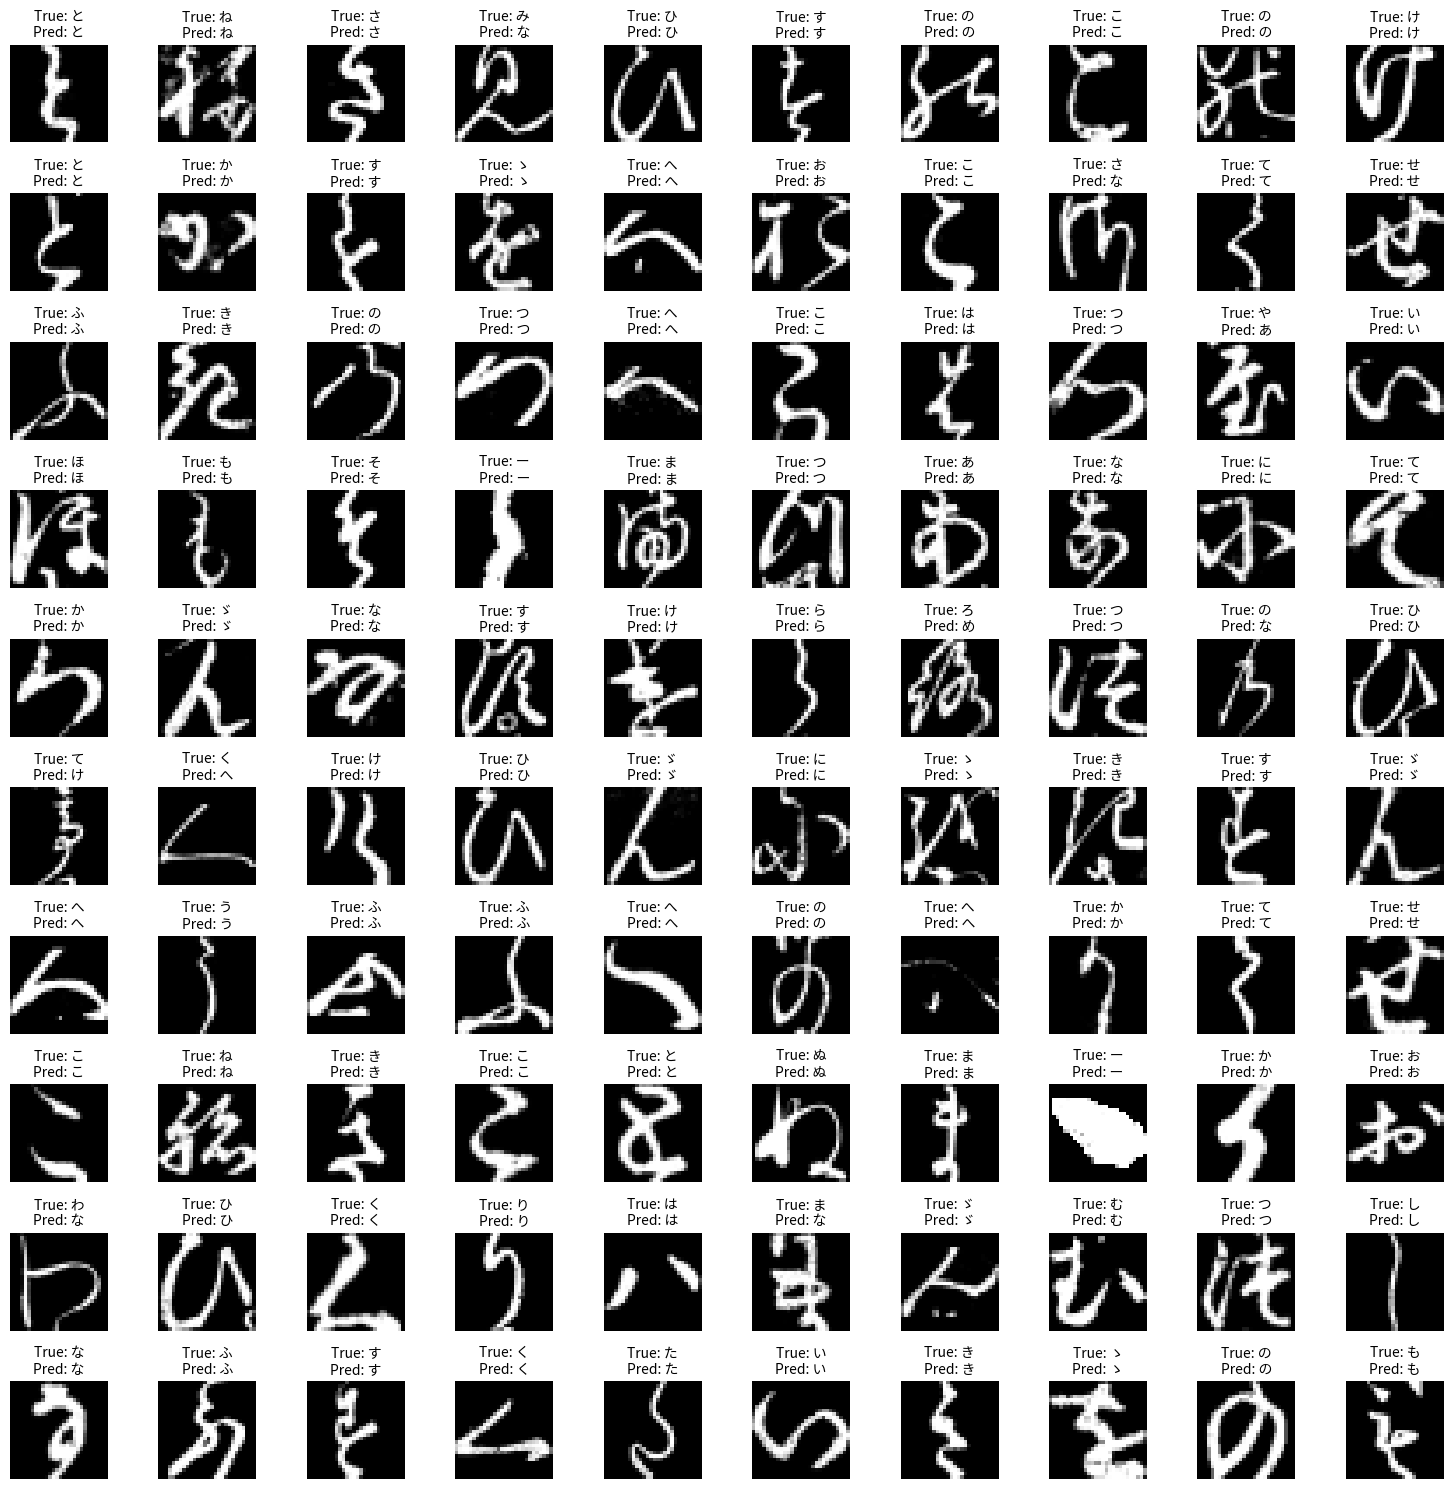

In [ ]:
n_samples = 100
rows = 10
cols = 10

images_list = []
labels_list = []

for batch_images, batch_labels in test_loader:
    images_list.append(batch_images)
    labels_list.append(batch_labels)
    if len(torch.cat(images_list)) >= n_samples:
        break

images = torch.cat(images_list)[:n_samples]
labels = torch.cat(labels_list)[:n_samples]

with torch.no_grad():
    outputs = model(images.to(device))
    preds = outputs.argmax(dim=1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, (image, label, pred) in enumerate(zip(images, labels, preds)):
    row, col = divmod(i, cols)
    axs[row, col].imshow(image.cpu().numpy().squeeze(), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label_map[label.item()]}\nPred: {label_map[pred.item()]}", fontproperties=prop)

for ax in axs.flat[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Summary

- Model: CNN
- Loss Function: Cross Entropy and Cosine Similarity
- Optimizer: Adam
- Other Hyperparameters:
    - Batch Size: 32 and 16
    - Learning Rate: 0.001 and 0.1
    - Number of Epochs: 5



## LSTM

### Cross Entropy Loss

In [ ]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to load the dataset
def load_k49_data():
    train_images = np.load(data_path + 'k49-train-imgs.npz')['arr_0']
    train_labels = np.load(data_path + 'k49-train-labels.npz')['arr_0']
    test_images = np.load(data_path + 'k49-test-imgs.npz')['arr_0']
    test_labels = np.load(data_path + 'k49-test-labels.npz')['arr_0']

    train_images = torch.tensor(train_images).float() / 255.0
    test_images = torch.tensor(test_images).float() / 255.0
    train_labels = torch.tensor(train_labels).long()
    test_labels = torch.tensor(test_labels).long()

    return train_images, train_labels, test_images, test_labels

# Load the dataset
train_images, train_labels, test_images, test_labels = load_k49_data()

# Convert the dataset to TensorDataset
train_dataset = TensorDataset(train_images.unsqueeze(1), train_labels)
test_dataset = TensorDataset(test_images.unsqueeze(1), test_labels)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=28, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Multiply by 2 because it's bidirectional

    def forward(self, x):
        x = x.view(x.size(0), 28, 28)  # Reshape to (batch, sequence_length, features)
        _, (h_n, _) = self.lstm(x)     # LSTM output, we take the hidden states
        h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Concatenate the hidden states from both directions
        out = self.fc(h_n)             # Classify
        return out

In [ ]:
# Training and evaluation function
def train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=5, batch_size=32):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects / len(dataloaders['val'].dataset)
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")

    return history

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

# Instantiate the model, loss function, and optimizer
model = LSTMClassifier(num_classes=49).to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Train and evaluate the model
history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

# Evaluate the model on the test set
model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

# Output final test accuracy
print(f"Test Accuracy: {test_acc:.4f}")

Epoch [1/5], Loss: 0.8536, Acc: 0.7689, Val Loss: 0.4478, Val Acc: 0.8734
Epoch [2/5], Loss: 0.3551, Acc: 0.9009, Val Loss: 0.3053, Val Acc: 0.9151
Epoch [3/5], Loss: 0.2159, Acc: 0.9395, Val Loss: 0.2241, Val Acc: 0.9367
Epoch [4/5], Loss: 0.1734, Acc: 0.9508, Val Loss: 0.2126, Val Acc: 0.9404
Epoch [5/5], Loss: 0.1241, Acc: 0.9657, Val Loss: 0.1885, Val Acc: 0.9476
Test Accuracy: 0.9010


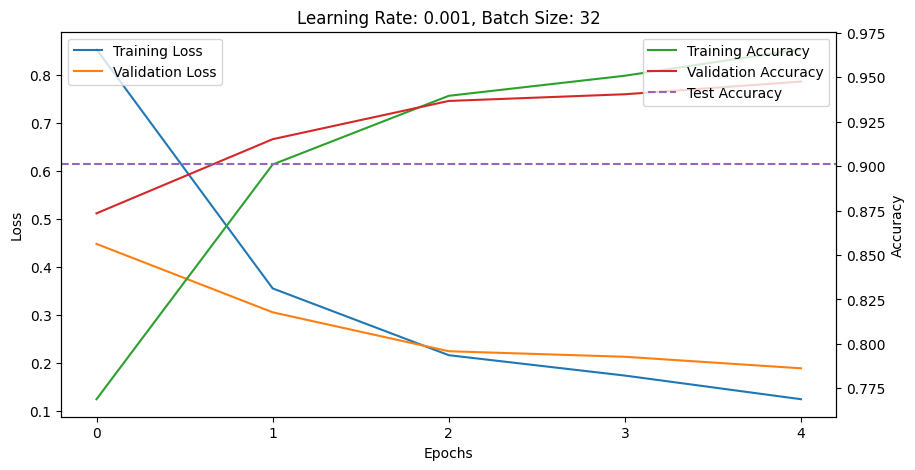

In [ ]:
plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Cosine Similarity Loss

Epoch [1/5], Loss: 0.2546, Acc: 0.7646, Val Loss: 0.1594, Val Acc: 0.8546
Epoch [2/5], Loss: 0.1361, Acc: 0.8754, Val Loss: 0.1261, Val Acc: 0.8841
Epoch [3/5], Loss: 0.0960, Acc: 0.9127, Val Loss: 0.0952, Val Acc: 0.9119
Epoch [4/5], Loss: 0.0839, Acc: 0.9250, Val Loss: 0.0884, Val Acc: 0.9186
Epoch [5/5], Loss: 0.0689, Acc: 0.9387, Val Loss: 0.0791, Val Acc: 0.9257


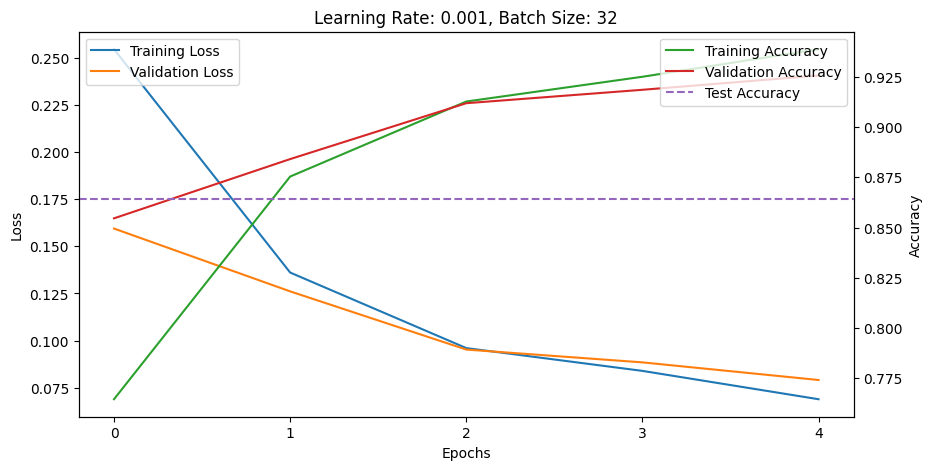

In [ ]:
import torch.nn.functional as F

class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        one_hot_targets = F.one_hot(targets, num_classes=inputs.size(1)).float()
        loss = 1 - F.cosine_similarity(inputs, one_hot_targets, dim=1)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

batch_size = 32
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Higher Learning Rate

In [ ]:
batch_size = 32
learning_rate = 0.1
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

Epoch [1/5], Loss: 2.7221, Acc: 0.3036, Val Loss: 2.4552, Val Acc: 0.3486
Epoch [2/5], Loss: 2.4934, Acc: 0.3393, Val Loss: 2.3979, Val Acc: 0.3660
Epoch [3/5], Loss: 2.1658, Acc: 0.4183, Val Loss: 2.2182, Val Acc: 0.4078


In [ ]:
batch_size = 32
learning_rate = 0.1
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Lower Batch Size

In [ ]:
batch_size = 8
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

In [ ]:
batch_size = 8
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

model = LSTMClassifier(num_classes=49).to(device)
criterion = CosineSimilarityLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

history = train_and_evaluate(model, criterion, optimizer, scheduler, dataloaders, num_epochs=num_epochs, batch_size=batch_size)

model.eval()
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
test_acc = running_corrects / len(test_loader.dataset)

plot_training_vs_epochs(history, test_acc, title=f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")

### Predicted Visualization

In [ ]:
n_samples = 100
rows = 10
cols = 10

images_list = []
labels_list = []

for batch_images, batch_labels in test_loader:
    images_list.append(batch_images)
    labels_list.append(batch_labels)
    if len(torch.cat(images_list)) >= n_samples:
        break

images = torch.cat(images_list)[:n_samples]
labels = torch.cat(labels_list)[:n_samples]

with torch.no_grad():
    outputs = model(images.to(device))
    preds = outputs.argmax(dim=1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, (image, label, pred) in enumerate(zip(images, labels, preds)):
    row, col = divmod(i, cols)
    axs[row, col].imshow(image.cpu().numpy().squeeze(), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f"True: {label_map[label.item()]}\nPred: {label_map[pred.item()]}", fontproperties=prop)

for ax in axs.flat[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Summary